<a href="https://colab.research.google.com/github/plaban1981/Feature_Selection/blob/master/Filter_Methods_Basics_Correlations_Univariate_ROC_AUCipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Filter Methods - Basics - Correlations - Univariate ROC-AUC

In [0]:
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

## load the Santander customer satisfaction dataset from Kaggle

In [3]:
from google.colab import files
files.upload()

Saving Santander_train.csv to Santander_train.csv


In [11]:
data = pd.read_csv('Santander_train.csv')
data.shape

(76020, 371)

## separate dataset into train and test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['TARGET'], axis=1),
    data['TARGET'],
    test_size=0.3,
    random_state=1)
 
X_train.shape, X_test.shape

((53214, 370), (22806, 370))

## Keep a copy of the dataset with all the variables to measure the performance of machine learning models at the end of the notebook

In [0]:
X_train_original = X_train.copy()
X_test_original = X_test.copy()

##Remove constant features

In [14]:
constant_features = [feat for feat in X_train.columns if X_train[feat].std() == 0]
print(constant_features)
#
X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)
#
X_train.shape, X_test.shape

['ind_var2_0', 'ind_var2', 'ind_var13_medio_0', 'ind_var13_medio', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var13_medio_0', 'num_var13_medio', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0', 'num_var46', 'saldo_var13_medio', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46', 'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3', 'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1', 'num_meses_var13_medio_ult3', 'num_reemb_var13_hace3', 'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3', 'saldo_var2_ult1', 'saldo_medio_var13_medio_hace2', 'saldo_medio_var13_medio_hace3', 'saldo_medio_var13_medio_ult1', 'saldo_medio_var13_medio_ult3']


((53214, 327), (22806, 327))

##Remove quasi-constant features

In [15]:
sel = VarianceThreshold(threshold=0.01)  # 0.01 indicates 99% of observations approximately
 
sel.fit(X_train)  # fit finds the features with low variance
 
sum(sel.get_support()) # how many not quasi-constant?

269

In [0]:
features_to_keep = X_train.columns[sel.get_support()]

In [17]:
# we can then remove the features like this
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)
 
X_train.shape, X_test.shape

((53214, 269), (22806, 269))

## sklearn transformations lead to numpy arrays .Transform the arrays back to dataframes

In [0]:
X_train= pd.DataFrame(X_train)
X_train.columns = features_to_keep
 
X_test= pd.DataFrame(X_test)
X_test.columns = features_to_keep

In [20]:
X_train.shape,X_test.shape

((53214, 269), (22806, 269))

## Remove duplicated features

In [0]:
X_train = X_train.drop_duplicates(keep='first')
X_test = X_test.drop_duplicates(keep='first')

In [23]:
# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)
 
    col_1 = X_train.columns[i]
 
    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260


16

In [24]:
X_train.shape,X_test.shape

((53214, 269), (22806, 269))

In [25]:
duplicated_feat

['ind_var26',
 'ind_var25',
 'ind_var37',
 'num_var26',
 'num_var25',
 'num_var32',
 'num_var37',
 'num_var39',
 'saldo_var29',
 'delta_num_reemb_var13_1y3',
 'delta_num_reemb_var17_1y3',
 'delta_num_reemb_var33_1y3',
 'delta_num_trasp_var17_in_1y3',
 'delta_num_trasp_var17_out_1y3',
 'delta_num_trasp_var33_in_1y3',
 'delta_num_trasp_var33_out_1y3']

In [26]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)
 
X_train.shape, X_test.shape

((53214, 253), (22806, 253))

In [0]:
# Keep a copy of the dataset except constant and duplicated variables
# to measure the performance of machine learning models
# at the end of the notebook
 
X_train_basic_filter = X_train.copy()
X_test_basic_filter = X_test.copy()

##Remove correlated features

In [0]:
# Create correlation matrix
df_corr = X_train.corr().abs()

In [33]:
# Select upper triangle of correlation matrix
import numpy as np
upper = df_corr.where(np.triu(np.ones(df_corr.shape),k=1).astype(np.bool))
upper

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13,ind_var14_0,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var25_0,...,num_var45_hace3,num_var45_ult1,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
ID,NaN,0.000693,0.005353,0.000690,0.001844,0.002232,0.005337,0.005283,0.006391,0.005840,0.010243,0.003557,0.000810,0.000033,0.001330,0.002920,0.000466,0.001614,0.001471,0.005926,0.004250,0.001369,0.002155,0.000734,0.001087,0.004552,0.009444,0.002147,0.002653,0.003567,0.000586,0.000413,0.002987,0.003916,0.009782,0.011560,0.000465,0.000314,0.001002,0.001378,...,0.001408,0.000343,0.000348,0.004462,0.007501,0.004571,0.002594,0.001879,0.005036,0.003630,0.003822,0.007979,0.007016,0.006958,0.006893,0.004340,0.000133,0.004375,0.004722,0.002769,0.002417,0.003395,0.004271,0.006154,0.000547,0.006233,0.004878,0.000820,0.000157,0.007195,0.009152,0.002319,0.001996,0.004407,0.004310,0.005680,0.003435,0.003635,0.003208,0.008756
var3,NaN,NaN,0.003410,0.001764,0.004574,0.005690,0.001563,0.001756,0.000550,0.000616,0.001334,0.004402,0.005544,0.000079,0.001392,0.002008,0.000041,0.001414,0.002141,0.000435,0.000344,0.008018,0.035051,0.007025,0.006548,0.010358,0.008407,0.009101,0.008185,0.008025,0.003993,0.003961,0.008960,0.006000,0.008125,0.007679,0.006296,0.006060,0.006431,0.005937,...,0.008048,0.007433,0.007096,0.004343,0.003887,0.003629,0.004308,0.001838,0.000702,0.002434,0.002379,0.004060,0.002451,0.004799,0.004878,0.005320,0.002975,0.005854,0.005814,0.002315,0.001467,0.002346,0.002388,0.000674,0.000292,0.000799,0.000861,0.000233,0.000167,0.000223,0.000268,0.000674,0.000485,0.000582,0.000608,0.000575,0.000514,0.000697,0.000769,0.000052
var15,NaN,NaN,NaN,0.040397,0.092375,0.099206,0.045242,0.052795,0.008735,0.009206,0.037703,0.084809,0.090087,0.085532,0.082997,0.103642,0.085277,0.082923,0.106287,0.013640,0.108934,0.120042,0.097694,0.117210,0.106289,0.264526,0.219967,0.303071,0.244760,0.242472,0.191412,0.191956,0.301864,0.152322,0.251101,0.241224,0.085507,0.096586,0.100069,0.083288,...,0.228360,0.154928,0.227385,0.173926,0.147660,0.127364,0.162532,0.054233,0.020494,0.064399,0.067084,0.161871,0.103263,0.187661,0.190046,0.190363,0.107205,0.210746,0.208718,0.125335,0.079274,0.123976,0.125667,0.040650,0.019041,0.041774,0.046375,0.009415,0.003421,0.012745,0.013871,0.030178,0.018317,0.029240,0.029662,0.027682,0.020785,0.033246,0.036761,0.006741
imp_ent_var16_ult1,NaN,NaN,NaN,NaN,0.041577,0.035345,0.009419,0.010578,0.000855,0.003151,0.012173,0.041441,0.034540,0.023863,0.020304,0.038071,0.023685,0.020331,0.038817,0.000226,0.021812,0.002271,0.016926,0.003877,0.005491,0.034847,0.040622,0.041212,0.03161

In [35]:
# Find features with correlation greater than 0.80
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
to_drop

['imp_op_var39_comer_ult3',
 'imp_op_var40_comer_ult3',
 'imp_op_var40_efect_ult3',
 'imp_op_var41_comer_ult1',
 'imp_op_var41_comer_ult3',
 'imp_op_var41_efect_ult3',
 'imp_op_var41_ult1',
 'imp_op_var39_efect_ult1',
 'imp_op_var39_efect_ult3',
 'imp_op_var39_ult1',
 'ind_var8_0',
 'ind_var8',
 'ind_var12',
 'ind_var13_corto_0',
 'ind_var13_corto',
 'ind_var13_largo',
 'ind_var13',
 'ind_var24_0',
 'ind_var24',
 'ind_var26_0',
 'ind_var26_cte',
 'ind_var25_0',
 'ind_var30',
 'ind_var37_0',
 'ind_var40_0',
 'ind_var41_0',
 'num_var1_0',
 'num_var5_0',
 'num_var5',
 'num_var8_0',
 'num_var8',
 'num_var12_0',
 'num_var12',
 'num_var13_0',
 'num_var13_corto_0',
 'num_var13_corto',
 'num_var13_largo_0',
 'num_var13_largo',
 'num_var13',
 'num_var17',
 'num_var20',
 'num_var24_0',
 'num_var24',
 'num_var26_0',
 'num_var25_0',
 'num_op_var40_ult3',
 'num_op_var41_ult3',
 'num_op_var39_hace2',
 'num_op_var39_hace3',
 'num_op_var39_ult1',
 'num_op_var39_ult3',
 'num_var30_0',
 'num_var30',
 'n

In [36]:
len(to_drop)

128

In [37]:
# removed correlated  features
X_train.drop(labels=to_drop, axis=1, inplace=True)
X_test.drop(labels=to_drop, axis=1, inplace=True)
 
X_train.shape, X_test.shape

((53214, 125), (22806, 125))

In [0]:
# keep a copy of the dataset at  this stage
X_train_corr = X_train.copy()
X_test_corr = X_test.copy()

##Remove features using univariate roc_auc

- # find important features using univariate roc-auc
- # loop to build a tree, make predictions and get the roc-auc for each feature of the train set

In [0]:
roc_values = []
for feature in X_train.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

In [42]:
df_roc = pd.DataFrame({'Features':X_train.columns,'ROC':roc_values})
df_roc.head()

,Features,ROC
0,ID,0.500512
1,var3,0.502106
2,var15,0.701030
3,imp_ent_var16_ult1,0.497959
4,imp_op_var39_comer_ult1,0.499298


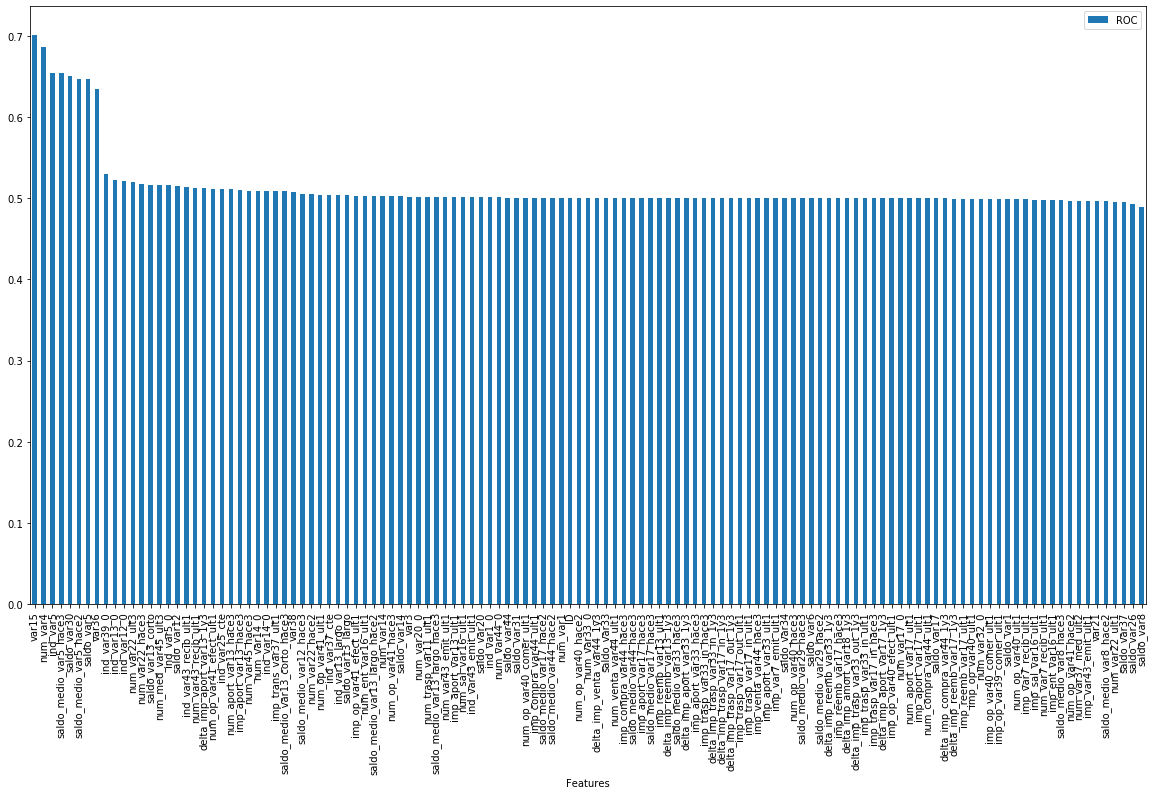

In [51]:
df_roc.sort_values(by='ROC',ascending=False).set_index('Features').plot.bar(figsize=(20, 11))
plt.show()

 - by removing features with univariate roc_auc == 0.50, we remove another 39 features
- here the selected features which have a ROC > 0.50 is 86
- total number of features is 125

In [56]:
df_roc[df_roc['ROC']>0.50].head()

,Features,ROC
0,ID,0.500512
1,var3,0.502106
2,var15,0.701030
8,imp_op_var41_efect_ult1,0.503363
10,ind_var1_0,0.501457


In [57]:
selected_feat = df_roc[df_roc['ROC']>0.5]
len(selected_feat), X_train.shape[1]

(86, 125)

In [62]:
selected_feat

,Features,ROC
0,ID,0.500512
1,var3,0.502106
2,var15,0.701030
8,imp_op_var41_efect_ult1,0.503363
10,ind_var1_0,0.501457
...,...,...
118,saldo_medio_var17_hace3,0.500182
121,saldo_medio_var33_hace3,0.500137
122,saldo_medio_var44_hace2,0.500616
123,saldo_medio_var44_hace3,0.500251


## Compare the performance in machine learning algorithms for different filtered features

#### create a function to build random forests and compare performance in train and test set

In [0]:
def run_randomForests(X_train, X_test, y_train, y_test):
  rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
  rf.fit(X_train,y_train)
  print('Train set')
  pred = rf.predict_proba(X_train)
  print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
  print('Test set')
  pred = rf.predict_proba(X_test)
  print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

#### original

In [59]:
run_randomForests(X_train_original.drop(labels=['ID'], axis=1),
                  X_test_original.drop(labels=['ID'], axis=1),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8065249945894206
Test set
Random Forests roc-auc: 0.7890248605641693


## filter methods - basic

In [60]:
run_randomForests(X_train_basic_filter.drop(labels=['ID'], axis=1),
                  X_test_basic_filter.drop(labels=['ID'], axis=1),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8058834175647219
Test set
Random Forests roc-auc: 0.7893567672719184


## filter methods - correlation

In [73]:
run_randomForests(X_train_corr.drop(labels=['ID'], axis=1),
                  X_test_corr.drop(labels=['ID'], axis=1),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8077692618287293
Test set
Random Forests roc-auc: 0.7925816070339918


## filter methods - univariate roc-auc

In [63]:
run_randomForests(X_train[selected_feat['Features']],X_test[selected_feat['Features']],y_train, y_test)

Train set
Random Forests roc-auc: 0.8079737819149474
Test set
Random Forests roc-auc: 0.7915463165873029


#### Note :

We can see that removing constant, quasi-constant, duplicated, correlated and now features with univariate roc-auc ==0.5 we still keep or even enhance the performance of the random forests (0.789 vs 0.791) at the time that we reduce the feature space dramatically (from 371 to 86).

## Checking the performance of logistic regression 

In [0]:
def run_logistic(X_train, X_test, y_train, y_test):
  lr = LogisticRegression(max_iter=200,random_state=44,solver='liblinear')
  lr.fit(X_train,y_train)
  print('Train set')
  pred = lr.predict_proba(X_train)
  print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
  print('Test set')
  pred = lr.predict_proba(X_test)
  print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

##original

In [71]:
scaler = StandardScaler().fit(X_train_original.drop(labels=['ID'], axis=1))
 
run_logistic(scaler.transform(X_train_original.drop(labels=['ID'], axis=1)),
             scaler.transform(X_test_original.drop(labels=['ID'], axis=1)),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8069421054352028
Test set
Logistic Regression roc-auc: 0.7892812309485755


## filter methods - basic

In [72]:
scaler = StandardScaler().fit(X_train_basic_filter.drop(labels=['ID'], axis=1))
 
run_logistic(scaler.transform(X_train_basic_filter.drop(labels=['ID'], axis=1)),
             scaler.transform(X_test_basic_filter.drop(labels=['ID'], axis=1)),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8062876706749105
Test set
Logistic Regression roc-auc: 0.7886641707584321


## filter methods - correlation

In [74]:
scaler = StandardScaler().fit(X_train_corr.drop(labels=['ID'], axis=1))
 
run_logistic(scaler.transform(X_train_corr.drop(labels=['ID'], axis=1)),
             scaler.transform(X_test_corr.drop(labels=['ID'], axis=1)),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.7963450622937921
Test set
Logistic Regression roc-auc: 0.7838809759684303


## filter methods - univariate roc-auc

In [76]:
scaler = StandardScaler().fit(X_train[selected_feat['Features']])
 
run_logistic(scaler.transform(X_train[selected_feat['Features']]),
             scaler.transform(X_test[selected_feat['Features']]),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.7935915330206204
Test set
Logistic Regression roc-auc: 0.7823928280140383
